# Global SST and SIC Visualization - March 2000

This notebook visualizes global Sea Surface Temperature (SST) and Sea Ice Concentration (SIC) data for March 2000.

## Setup and Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import urllib.request
import gzip
import shutil
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

## Data Download Setup

In [2]:
cwd = os.getcwd()
data_dir = Path("hadisst_data")
data_dir.mkdir(exist_ok=True)

sst_url = "https://www.metoffice.gov.uk/hadobs/hadisst/data/HadISST_sst.nc.gz"
ice_url = "https://www.metoffice.gov.uk/hadobs/hadisst/data/HadISST_ice.nc.gz"

sst_gz = data_dir / "HadISST_sst.nc.gz"
ice_gz = data_dir / "HadISST_ice.nc.gz"
sst_nc = data_dir / "HadISST_sst.nc"
ice_nc = data_dir / "HadISST_ice.nc"

## Download and Decompress Data

In [3]:
def download_if_needed(url, path):
    if not path.exists():
        print(f"Downloading {path.name} ...")
        urllib.request.urlretrieve(url, path)
    else:
        print(f"{path.name} exists. Skipping download.")

def gunzip_if_needed(gz_path, nc_path):
    if not nc_path.exists():
        print(f"Decompressing {gz_path.name} ...")
        with gzip.open(gz_path, "rb") as fin, open(nc_path, "wb") as fout:
            shutil.copyfileobj(fin, fout)
    else:
        print(f"{nc_path.name} exists. Skipping decompress.")

download_if_needed(sst_url, sst_gz)
gunzip_if_needed(sst_gz, sst_nc)

download_if_needed(ice_url, ice_gz)
gunzip_if_needed(ice_gz, ice_nc)

HadISST_sst.nc.gz exists. Skipping download.
HadISST_sst.nc exists. Skipping decompress.
HadISST_ice.nc.gz exists. Skipping download.
HadISST_ice.nc exists. Skipping decompress.


## Open and Merge Datasets

In [4]:
# Open both datasets
ds_sst = xr.open_dataset(sst_nc)
ds_ice = xr.open_dataset(ice_nc)

# Pick correct ice variable name
if "sic" in ds_ice.data_vars:
    ice_var = "sic"
elif "ice" in ds_ice.data_vars:
    ice_var = "ice"
else:
    ice_var = list(ds_ice.data_vars)[0]

# Merge datasets (no filtering - keeping global coverage)
ds_full = xr.merge([
    ds_sst[["sst"]],
    ds_ice[[ice_var]].rename({ice_var: "ice"})
])

print("Dataset shape:", ds_full.sst.shape)
print(f"Global coverage: lat [{ds_full.latitude.values.min():.1f}, {ds_full.latitude.values.max():.1f}], lon [{ds_full.longitude.values.min():.1f}, {ds_full.longitude.values.max():.1f}]")
print(f"Time range: {ds_full.time.values[0]} to {ds_full.time.values[-1]}")

Dataset shape: (1870, 180, 360)
Global coverage: lat [-89.5, 89.5], lon [-179.5, 179.5]
Time range: 1870-01-16T11:59:59.505615234 to 2025-10-16T12:00:00.000000000


## Select March 2000 Data

In [5]:
# Select March 2000
ds_march2000 = ds_full.sel(time="2000-03", method='nearest')

# Extract SST and SIC
sst_march2000 = ds_march2000["sst"]
sic_march2000 = ds_march2000["ice"]

print(f"Selected time: {ds_march2000.time.values}")
print(f"SST shape: {sst_march2000.shape}")
print(f"SIC shape: {sic_march2000.shape}")

Selected time: 2000-02-15T12:00:00.000000000
SST shape: (180, 360)
SIC shape: (180, 360)


## Global Visualization - March 2000

Selected time: 2000-09-16T00:00:00.000000000
SST shape: (180, 360)
SIC shape: (180, 360)


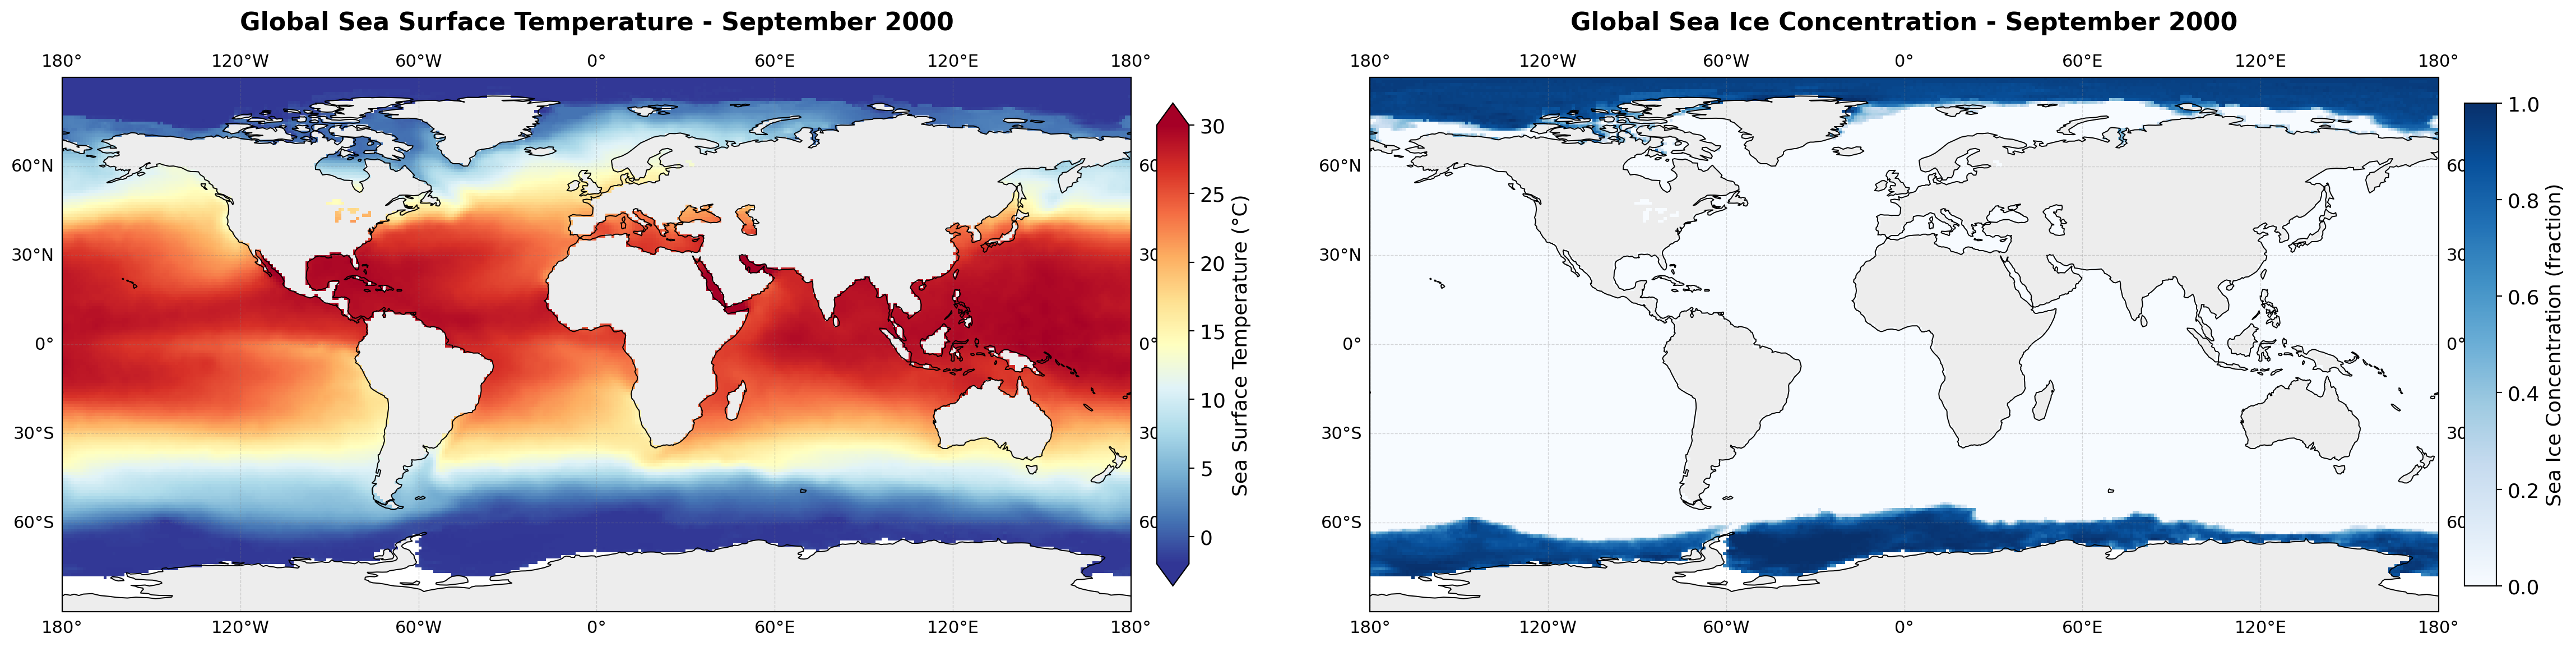

In [15]:
# ========== USER INPUTS ==========
year = 2000
month = 9  # 1=January, 2=February, ..., 12=December
# =================================

# Select the specified month and year
time_string = f"{year}-{month:02d}"
ds_selected = ds_full.sel(time=time_string, method='nearest')

# Extract SST and SIC
sst_selected = ds_selected["sst"]
sic_selected = ds_selected["ice"]

print(f"Selected time: {ds_selected.time.values}")
print(f"SST shape: {sst_selected.shape}")
print(f"SIC shape: {sic_selected.shape}")

# Clean SIC data (remove invalid values)
sic_clean = sic_selected.where((sic_selected >= 0) & (sic_selected <= 1))

# Create figure with two subplots
fig, axes = plt.subplots(
    figsize=(24, 9),
    ncols=2,
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Get month name for title
month_names = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
month_name = month_names[month - 1]

# ========== SST Plot (left) ==========
sst_selected.plot(
    ax=axes[0],
    transform=ccrs.PlateCarree(),
    cmap='RdYlBu_r',
    vmin=-2, vmax=30,
    cbar_kwargs={
        'label': 'Sea Surface Temperature (°C)',
        'shrink': 0.5,
        'aspect': 15,
        'pad': 0.02
    },
    add_colorbar=True
)

axes[0].coastlines(resolution='110m', linewidth=0.7, color='black')
axes[0].add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.4)
axes[0].gridlines(
    draw_labels=True,
    linewidth=0.5,
    color='gray',
    alpha=0.3,
    linestyle='--',
    xlabel_style={'size': 11},
    ylabel_style={'size': 11}
)
axes[0].set_title(
    f'Global Sea Surface Temperature - {month_name} {year}',
    fontsize=16,
    fontweight='bold',
    pad=15
)

# ========== SIC Plot (right) ==========
sic_clean.plot(
    ax=axes[1],
    transform=ccrs.PlateCarree(),
    cmap='Blues',
    vmin=0, vmax=1,
    cbar_kwargs={
        'label': 'Sea Ice Concentration (fraction)',
        'shrink': 0.5,
        'aspect': 15,
        'pad': 0.02
    },
    add_colorbar=True
)

axes[1].coastlines(resolution='110m', linewidth=0.7, color='black')
axes[1].add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.4)
axes[1].gridlines(
    draw_labels=True,
    linewidth=0.5,
    color='gray',
    alpha=0.3,
    linestyle='--',
    xlabel_style={'size': 11},
    ylabel_style={'size': 11}
)
axes[1].set_title(
    f'Global Sea Ice Concentration - {month_name} {year}',
    fontsize=16,
    fontweight='bold',
    pad=15
)

plt.tight_layout()
plt.show()

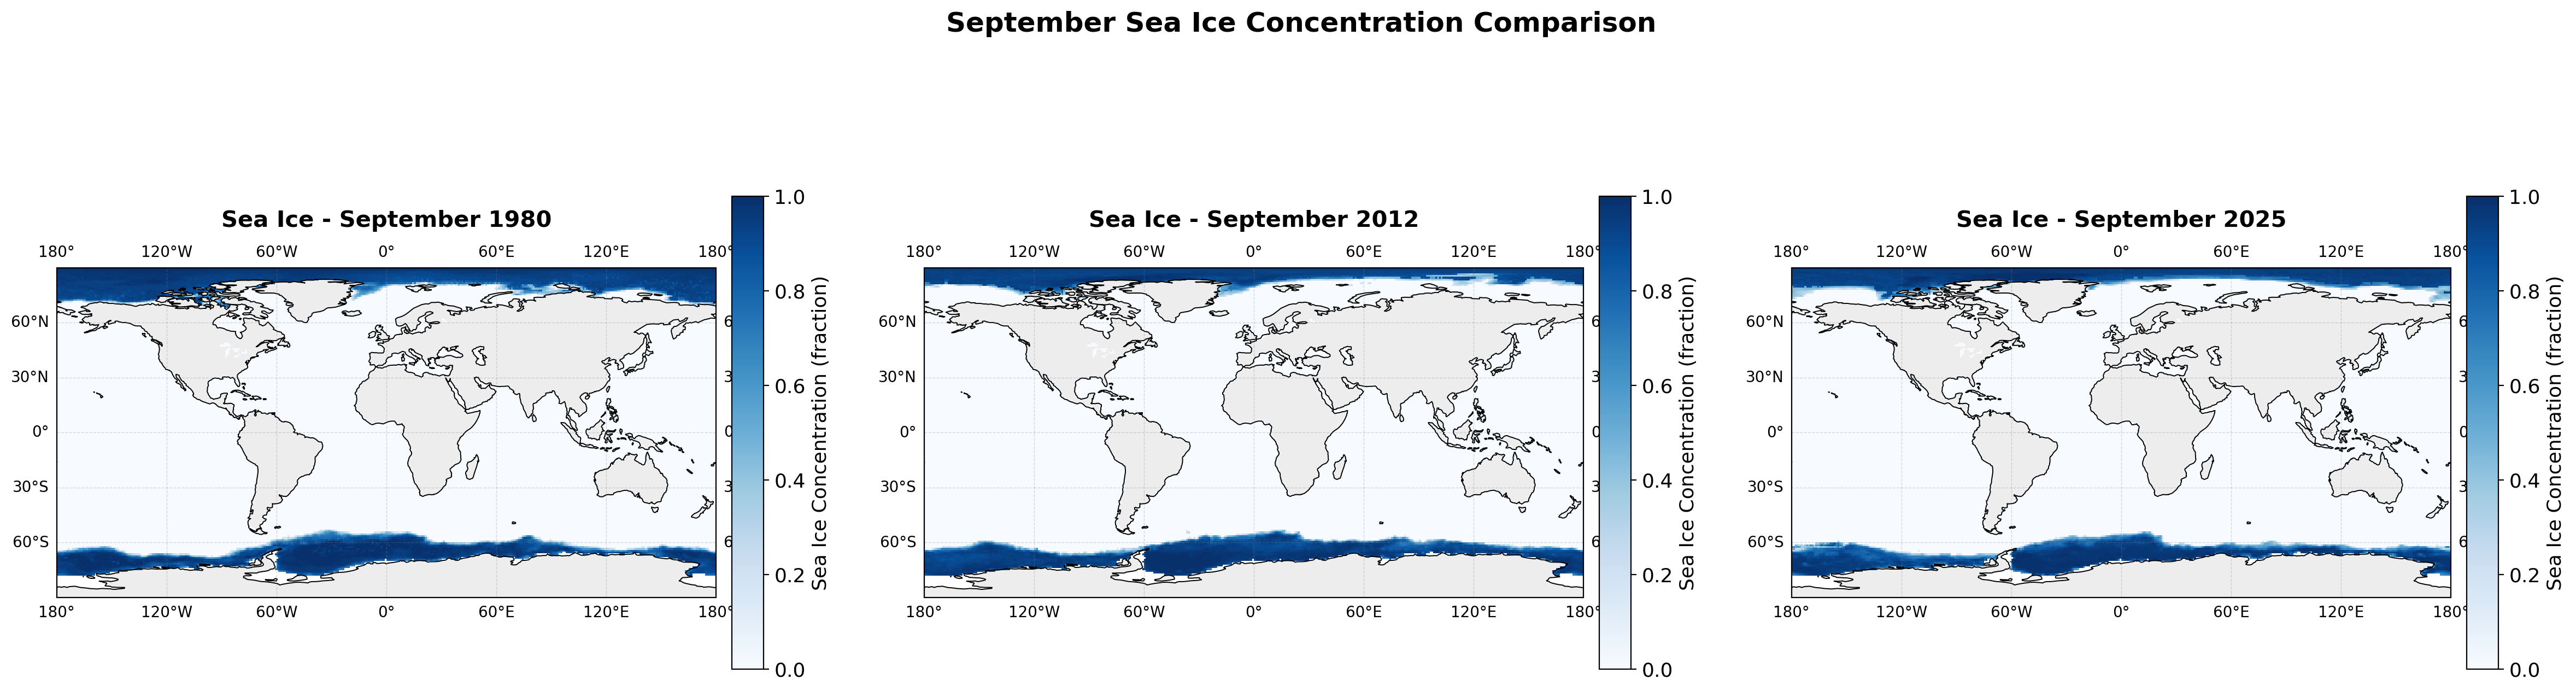

In [19]:
# ========== Multi-Year September Ice Comparison ==========
years_to_compare = [1980, 2012, 2025]
month = 9  # September

# Create figure with subplots (1 row x 3 columns)
fig, axes = plt.subplots(
    figsize=(24, 7),
    nrows=1,
    ncols=3,
    subplot_kw={'projection': ccrs.PlateCarree()}
)

for i, year in enumerate(years_to_compare):
    time_string = f"{year}-{month:02d}"
    ds_year = ds_full.sel(time=time_string, method='nearest')
    
    sic_year = ds_year["ice"]
    sic_clean_year = sic_year.where((sic_year >= 0) & (sic_year <= 1))
    
    # ========== SIC Plot ==========
    sic_clean_year.plot(
        ax=axes[i],
        transform=ccrs.PlateCarree(),
        cmap='Blues',
        vmin=0, vmax=1,
        cbar_kwargs={
            'label': 'Sea Ice Concentration (fraction)',
            'shrink': 0.7,
            'aspect': 15,
            'pad': 0.02
        },
        add_colorbar=True
    )
    
    axes[i].coastlines(resolution='110m', linewidth=0.7, color='black')
    axes[i].add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.4)
    axes[i].gridlines(
        draw_labels=True,
        linewidth=0.5,
        color='gray',
        alpha=0.3,
        linestyle='--',
        xlabel_style={'size': 10},
        ylabel_style={'size': 10}
    )
    axes[i].set_title(
        f'Sea Ice - September {year}',
        fontsize=15,
        fontweight='bold',
        pad=12
    )

plt.suptitle(
    'September Sea Ice Concentration Comparison',
    fontsize=18,
    fontweight='bold',
    y=1.02
)
plt.tight_layout()
plt.show()

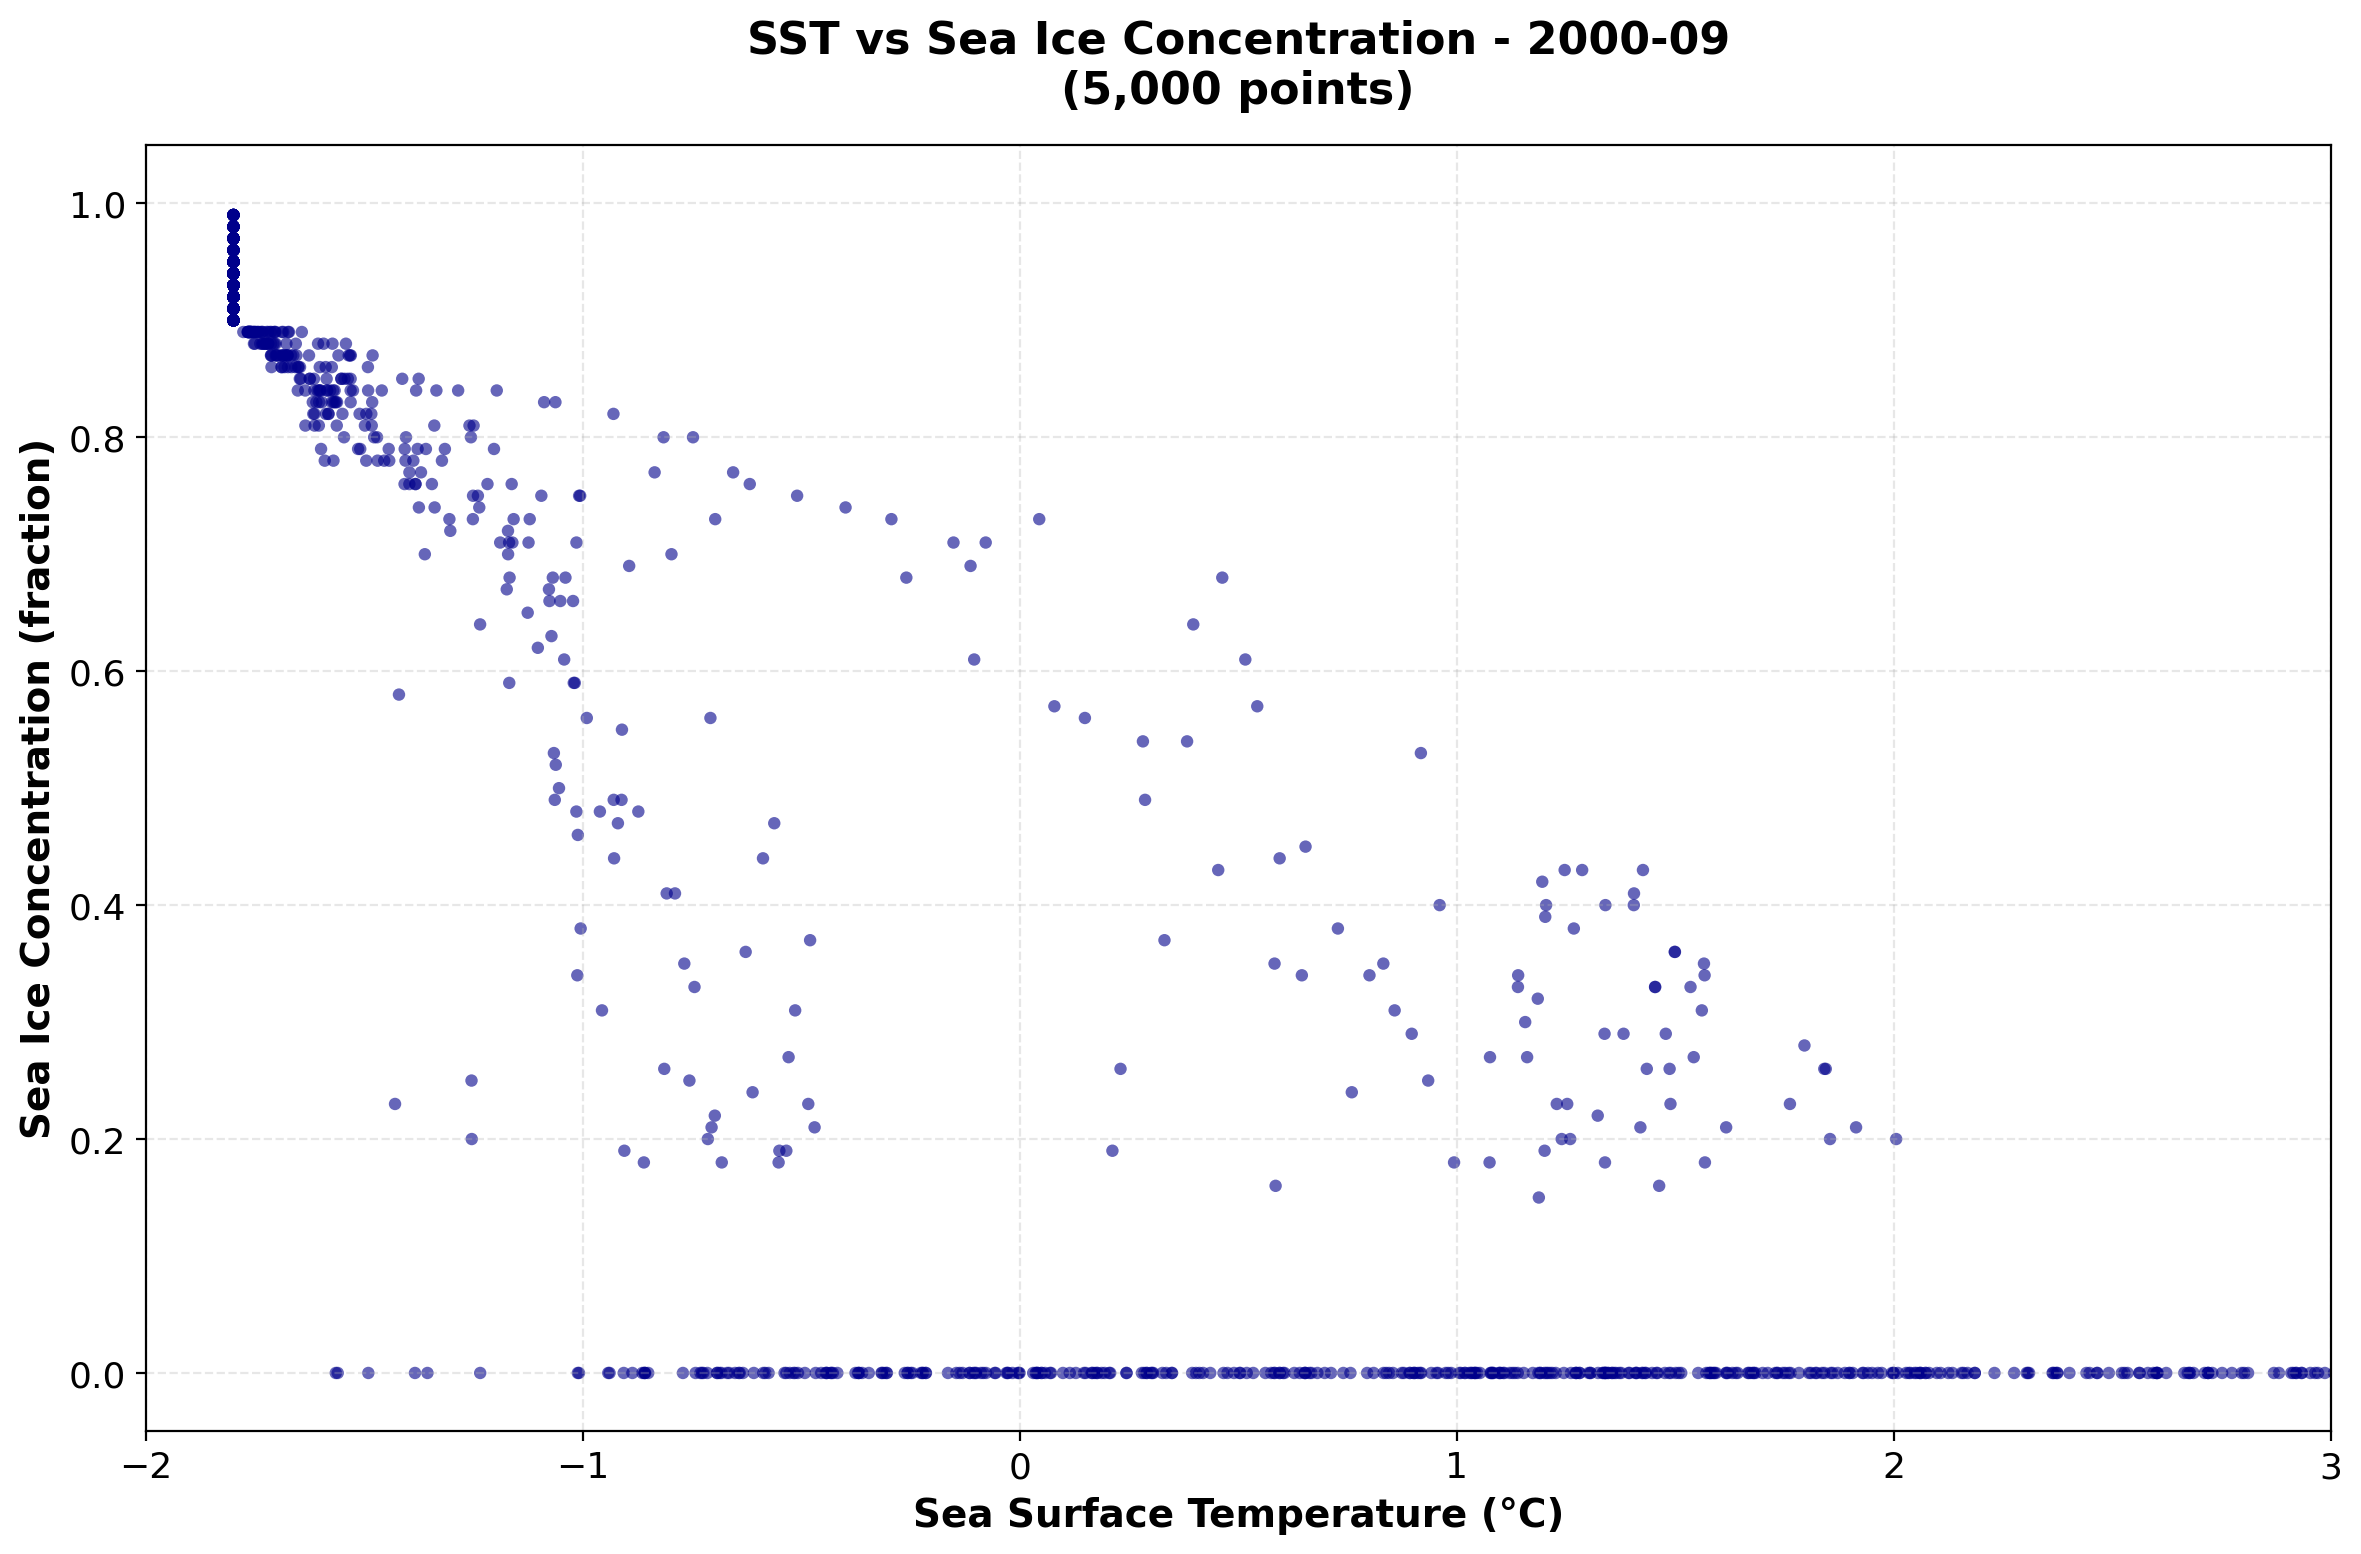


Statistics for 2000-09:
Total valid points: 43,094
Points plotted: 5,000

SST range: -1.80°C to 32.53°C
SIC range: 0.000 to 0.990

Points with ice (SIC > 0.1): 928 (18.6%)


In [24]:
# ========== Temperature vs Sea Ice Concentration Scatter Plot ==========

# Select a specific time period for analysis
year = 2000
month = 9  # September

time_string = f"{year}-{month:02d}"
ds_scatter = ds_full.sel(time=time_string, method='nearest')

# Get SST and SIC data
sst_data = ds_scatter["sst"].values.flatten()
sic_data = ds_scatter["ice"].values.flatten()

# Clean the data
# Remove invalid SST values (ice indicators < -5, and unrealistic values)
valid_mask = (sst_data > -5) & (sst_data < 40) & (sic_data >= 0) & (sic_data <= 1)
sst_clean = sst_data[valid_mask]
sic_clean = sic_data[valid_mask]

# Subsample for visualization (optional - use all points or subset)
n_points = 5000  # Adjust this number (use None to plot all points)
if n_points is not None and len(sst_clean) > n_points:
    indices = np.random.choice(len(sst_clean), n_points, replace=False)
    sst_subset = sst_clean[indices]
    sic_subset = sic_clean[indices]
else:
    sst_subset = sst_clean
    sic_subset = sic_clean

# Create scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(
    sst_subset, 
    sic_subset,
    c='darkblue',
    alpha=0.6,
    s=20,
    edgecolors='none'
)

ax.set_xlabel('Sea Surface Temperature (°C)', fontsize=14, fontweight='bold')
ax.set_ylabel('Sea Ice Concentration (fraction)', fontsize=14, fontweight='bold')
ax.set_title(f'SST vs Sea Ice Concentration - {year}-{month:02d}\n({len(sst_subset):,} points)', 
             fontsize=16, fontweight='bold', pad=15)

ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim(-2, 3)
ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"\nStatistics for {year}-{month:02d}:")
print(f"Total valid points: {len(sst_clean):,}")
print(f"Points plotted: {len(sst_subset):,}")
print(f"\nSST range: {sst_subset.min():.2f}°C to {sst_subset.max():.2f}°C")
print(f"SIC range: {sic_subset.min():.3f} to {sic_subset.max():.3f}")
print(f"\nPoints with ice (SIC > 0.1): {(sic_subset > 0.1).sum():,} ({100*(sic_subset > 0.1).sum()/len(sic_subset):.1f}%)")

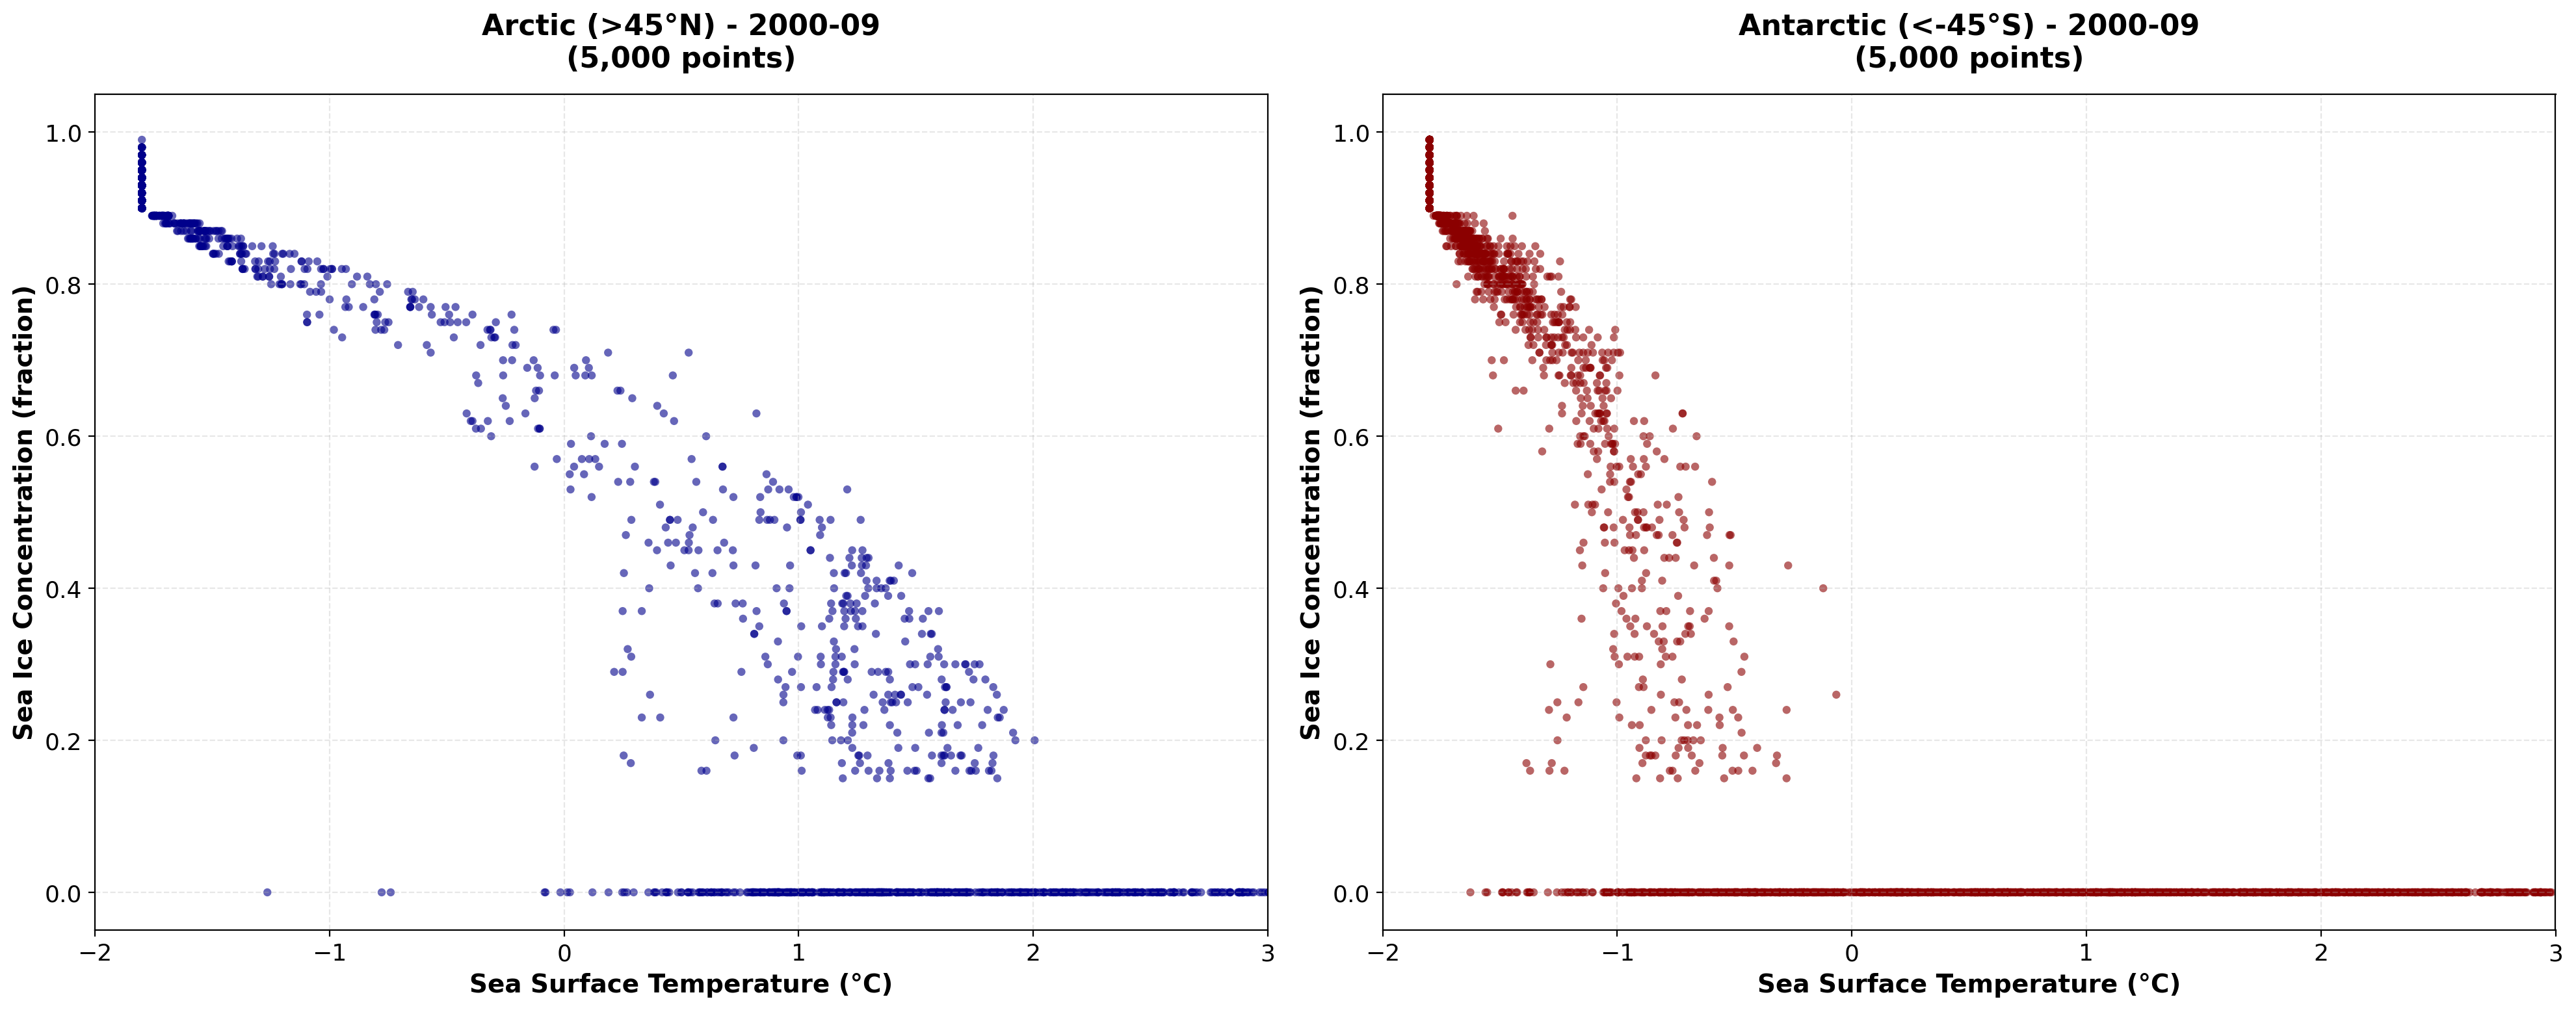


ARCTIC REGION (>45°N) - 2000-09
Total points: 9,443
Points plotted: 5,000
SST range: -1.80°C to 21.16°C
SIC range: 0.000 to 0.990
Points with ice (SIC > 0.1): 4,512 (47.8%)

ANTARCTIC REGION (<-45°S) - 2000-09
Total points: 9,150
Points plotted: 5,000
SST range: -1.80°C to 11.82°C
SIC range: 0.000 to 0.990
Points with ice (SIC > 0.1): 3,677 (40.2%)


In [25]:
# ========== Temperature vs Sea Ice Concentration - Arctic vs Antarctic ==========

# Select a specific time period for analysis
year = 2000
month = 9  # September

time_string = f"{year}-{month:02d}"
ds_scatter = ds_full.sel(time=time_string, method='nearest')

# Get SST, SIC, and latitude data
sst_data = ds_scatter["sst"].values
sic_data = ds_scatter["ice"].values
lat_data = ds_scatter["latitude"].values
lon_data = ds_scatter["longitude"].values

# Create meshgrid for latitude
lat_grid, lon_grid = np.meshgrid(lat_data, lon_data, indexing='ij')

# Flatten arrays
sst_flat = sst_data.flatten()
sic_flat = sic_data.flatten()
lat_flat = lat_grid.flatten()

# Clean the data
valid_mask = (sst_flat > -5) & (sst_flat < 40) & (sic_flat >= 0) & (sic_flat <= 1)
sst_clean = sst_flat[valid_mask]
sic_clean = sic_flat[valid_mask]
lat_clean = lat_flat[valid_mask]

# Separate Arctic (lat > 45) and Antarctic (lat < -45)
arctic_mask = lat_clean > 45
antarctic_mask = lat_clean < -45

sst_arctic = sst_clean[arctic_mask]
sic_arctic = sic_clean[arctic_mask]

sst_antarctic = sst_clean[antarctic_mask]
sic_antarctic = sic_clean[antarctic_mask]

# Subsample for visualization
n_points = 5000

if len(sst_arctic) > n_points:
    indices = np.random.choice(len(sst_arctic), n_points, replace=False)
    sst_arctic_plot = sst_arctic[indices]
    sic_arctic_plot = sic_arctic[indices]
else:
    sst_arctic_plot = sst_arctic
    sic_arctic_plot = sic_arctic

if len(sst_antarctic) > n_points:
    indices = np.random.choice(len(sst_antarctic), n_points, replace=False)
    sst_antarctic_plot = sst_antarctic[indices]
    sic_antarctic_plot = sic_antarctic[indices]
else:
    sst_antarctic_plot = sst_antarctic
    sic_antarctic_plot = sic_antarctic

# Create figure with two subplots
fig, axes = plt.subplots(figsize=(20, 8), ncols=2)

# ========== Arctic Plot (left) ==========
axes[0].scatter(
    sst_arctic_plot, 
    sic_arctic_plot,
    c='darkblue',
    alpha=0.6,
    s=20,
    edgecolors='none'
)

axes[0].set_xlabel('Sea Surface Temperature (°C)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Sea Ice Concentration (fraction)', fontsize=14, fontweight='bold')
axes[0].set_title(f'Arctic (>45°N) - {year}-{month:02d}\n({len(sst_arctic_plot):,} points)', 
                  fontsize=16, fontweight='bold', pad=15)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_xlim(-2, 3)
axes[0].set_ylim(-0.05, 1.05)

# ========== Antarctic Plot (right) ==========
axes[1].scatter(
    sst_antarctic_plot, 
    sic_antarctic_plot,
    c='darkred',
    alpha=0.6,
    s=20,
    edgecolors='none'
)

axes[1].set_xlabel('Sea Surface Temperature (°C)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Sea Ice Concentration (fraction)', fontsize=14, fontweight='bold')
axes[1].set_title(f'Antarctic (<-45°S) - {year}-{month:02d}\n({len(sst_antarctic_plot):,} points)', 
                  fontsize=16, fontweight='bold', pad=15)
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].set_xlim(-2, 3)
axes[1].set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n{'='*60}")
print(f"ARCTIC REGION (>45°N) - {year}-{month:02d}")
print(f"{'='*60}")
print(f"Total points: {len(sst_arctic):,}")
print(f"Points plotted: {len(sst_arctic_plot):,}")
print(f"SST range: {sst_arctic.min():.2f}°C to {sst_arctic.max():.2f}°C")
print(f"SIC range: {sic_arctic.min():.3f} to {sic_arctic.max():.3f}")
print(f"Points with ice (SIC > 0.1): {(sic_arctic > 0.1).sum():,} ({100*(sic_arctic > 0.1).sum()/len(sst_arctic):.1f}%)")

print(f"\n{'='*60}")
print(f"ANTARCTIC REGION (<-45°S) - {year}-{month:02d}")
print(f"{'='*60}")
print(f"Total points: {len(sst_antarctic):,}")
print(f"Points plotted: {len(sst_antarctic_plot):,}")
print(f"SST range: {sst_antarctic.min():.2f}°C to {sst_antarctic.max():.2f}°C")
print(f"SIC range: {sic_antarctic.min():.3f} to {sic_antarctic.max():.3f}")
print(f"Points with ice (SIC > 0.1): {(sic_antarctic > 0.1).sum():,} ({100*(sic_antarctic > 0.1).sum()/len(sst_antarctic):.1f}%)")